<a href="https://colab.research.google.com/github/Peksyaji/Orbit-AI-Mastery/blob/main/Copy_of_AIM0403D2204_Lab_1_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIM0403D2203 Text Classification (Machine Learning)
---
Hari ini, kita akan menyelesaikan kasus klasifikasi sentimen cuitan Twitter mengenai tayangan televisi menggunakan skema seperti gambar di bawah ini.

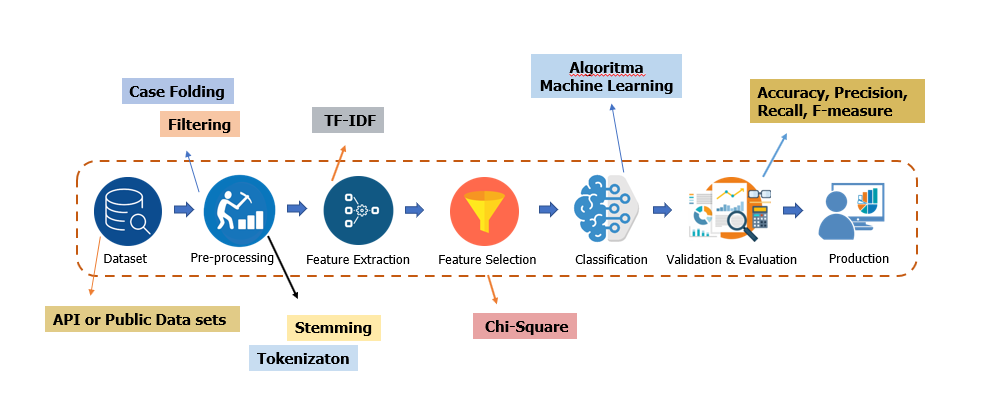

Langkah-langkah penyelesaian meliputi:
1. Data Acquisition
2. Text Preprocessing
   1. Tokenisasi
   2. Menghapus stopword
   3. lemmetizing words
3. Feature Engineering
   1. Feature Extraction - BoW & TF IDF
   2. Feature Selection - Chi-Square
4. Modelling (Machine Learning)
5. Model Evaluation
6. Deployment


In [1]:
# Install library Sastrawi dan emot
!pip -q install sastrawi
!pip install emot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 16.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 KB 6.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
from emot.emo_unicode import UNICODE_EMOJI
emoji = list(UNICODE_EMOJI.keys())
factory = StopWordRemoverFactory()
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# 01 Data Acquisition

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_tweet_sentimen_tayangan_tv.csv')
df.head()

,Id,Sentiment,Acara TV,Jumlah Retweet,Text Tweet
0,1,positive,HitamPutihTransTV,12,"Undang @N_ShaniJKT48 ke hitamputih, pemenang S..."
1,2,positive,HitamPutihTransTV,6,Selamat berbuka puasa Semoga amal ibadah hari ...
2,3,positive,HitamPutihTransTV,9,"Ada nih di trans7 hitam putih, dia dpt penghar..."
3,4,positive,HitamPutihTransTV,2,selamat ya mas @adietaufan masuk hitamputih
4,5,positive,HitamPutihTransTV,1,Asiknya nonton Hitam Putih Trans7


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              400 non-null    int64 
 1   Sentiment       400 non-null    object
 2   Acara TV        400 non-null    object
 3   Jumlah Retweet  400 non-null    int64 
 4   Text Tweet      400 non-null    object
dtypes: int64(2), object(3)
memory usage: 15.8+ KB


In [5]:
def polaritas(teks):
  if teks =='positive':
    return 1
  elif teks =='negative':
    return -1

In [6]:
df['label'] = df['Sentiment'].apply(polaritas)
df

,Id,Sentiment,Acara TV,Jumlah Retweet,Text Tweet,label
0,1,positive,HitamPutihTransTV,12,"Undang @N_ShaniJKT48 ke hitamputih, pemenang S...",1
1,2,positive,HitamPutihTransTV,6,Selamat berbuka puasa Semoga amal ibadah hari ...,1
2,3,positive,HitamPutihTransTV,9,"Ada nih di trans7 hitam putih, dia dpt penghar...",1
3,4,positive,HitamPutihTransTV,2,selamat ya mas @adietaufan masuk hitamputih,1
4,5,positive,HitamPutihTransTV,1,Asiknya nonton Hitam Putih Trans7,1
...,...,...,...,...,...,...
395,396,negative,MataNajwaMetroTV,0,ini apa banget deh gw paling kesel klo orang2 ...,-1
396,397,negative,MataNajwaMetroTV,0,Orang miskin semakin miskin klo sekolah melaku...,-1
397,398,negative,MataNajwaMetroTV,0,"ga boLeh emosi, cepat tua, nonton #matanajwame...",-1
398,399,negative,MataNajwaMetroTV,0,dr penampilan saja kyk preman taunya bkin kisr...,-1


In [7]:
print('Total Tweet:', df.shape[0], 'cuitan\n')
print('terdiri dari (label):')
print('-- [1] positif\t:', df[df.label == 1].shape[0], 'cuitan')
print('-- [-1] negatif\t:', df[df.label == -1].shape[0], 'cuitan\n')

Total Tweet: 400 cuitan

terdiri dari (label):
-- [1] positif	: 200 cuitan
-- [-1] negatif	: 200 cuitan



# 02 Text Preprocessing

In [8]:
Sastrawi_StopWords_id = factory.get_stop_words()

print(Sastrawi_StopWords_id)
print(len(Sastrawi_StopWords_id))

Sastrawi_StopWords_id = set(Sastrawi_StopWords_id)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

In [9]:
# function for preprocessing tweet in preparation for sentiment analysis
def processed_tweets(text):
    text = text.lower() 
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text).split())
    text = re.sub(r'\@\w+|\#\w+|\d+', '', text)
    punct = str.maketrans('', '', string.punctuation+string.digits)
    text = text.translate(punct)
    # tokenizing words and removing stop words from the tweet text
    tokens = word_tokenize(text)  
    filtered_words = [w for w in tokens if w not in Sastrawi_StopWords_id]
    filtered_words = [w for w in filtered_words if w not in emoji]
    # lemmetizing words
    lemmatizer = WordNetLemmatizer() 
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    text = " ".join(lemma_words)
    return text

In [10]:
# Preprocessing
df['text_tweet_bersih'] = df['Text Tweet'].apply(processed_tweets)
df

,Id,Sentiment,Acara TV,Jumlah Retweet,Text Tweet,label,text_tweet_bersih
0,1,positive,HitamPutihTransTV,12,"Undang @N_ShaniJKT48 ke hitamputih, pemenang S...",1,undang shanijkt hitamputih pemenang ssk jkt ha...
1,2,positive,HitamPutihTransTV,6,Selamat berbuka puasa Semoga amal ibadah hari ...,1,selamat berbuka puasa semoga amal ibadah hari ...
2,3,positive,HitamPutihTransTV,9,"Ada nih di trans7 hitam putih, dia dpt penghar...",1,nih trans hitam putih dpt penghargaan norwegia
3,4,positive,HitamPutihTransTV,2,selamat ya mas @adietaufan masuk hitamputih,1,selamat ma masuk hitamputih
4,5,positive,HitamPutihTransTV,1,Asiknya nonton Hitam Putih Trans7,1,asiknya nonton hitam putih trans
...,...,...,...,...,...,...,...
395,396,negative,MataNajwaMetroTV,0,ini apa banget deh gw paling kesel klo orang2 ...,-1,apa banget deh gw paling kesel klo orang debat...
396,397,negative,MataNajwaMetroTV,0,Orang miskin semakin miskin klo sekolah melaku...,-1,orang miskin semakin miskin klo sekolah melaku...
397,398,negative,MataNajwaMetroTV,0,"ga boLeh emosi, cepat tua, nonton #matanajwame...",-1,ga emosi cepat tua nonton lihat bapak tiba iku...
398,399,negative,MataNajwaMetroTV,0,dr penampilan saja kyk preman taunya bkin kisr...,-1,dr penampilan kyk preman taunya bkin kisruh pe...


In [11]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
df.to_csv('clean_data.csv')

# 03 Feature Engineering

In [12]:
# Pisahkan kolom fitur dan target
X = df['text_tweet_bersih']
y = df['label']

In [13]:
X

0      undang shanijkt hitamputih pemenang ssk jkt ha...
1      selamat berbuka puasa semoga amal ibadah hari ...
2         nih trans hitam putih dpt penghargaan norwegia
3                            selamat ma masuk hitamputih
4                       asiknya nonton hitam putih trans
                             ...                        
395    apa banget deh gw paling kesel klo orang debat...
396    orang miskin semakin miskin klo sekolah melaku...
397    ga emosi cepat tua nonton lihat bapak tiba iku...
398    dr penampilan kyk preman taunya bkin kisruh pe...
399    jawab aja ga usah berbelitbelit muter ga jelas...
Name: text_tweet_bersih, Length: 400, dtype: object

In [14]:
y

0      1
1      1
2      1
3      1
4      1
      ..
395   -1
396   -1
397   -1
398   -1
399   -1
Name: label, Length: 400, dtype: int64

## Feature Extraction (Bag of Words & N-Gram)
Proses mengubah teks menjadi vektor menggunakan metode BoW

In [15]:
'''
Convert a collection of text documents to a matrix of token counts.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
'''
from sklearn.feature_extraction.text import CountVectorizer

# BoW - Unigram
bow = CountVectorizer(ngram_range=(1,1))
bow.fit(X)

CountVectorizer()

In [16]:
# Melihat jumlah fitur
print(len(bow.get_feature_names_out()))

1517


In [17]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(bow.get_feature_names_out())

['aa' 'aba' 'abang' ... 'yuk' 'zaitun' 'zhonk']


In [18]:
# Melihat matriks jumlah fitur
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_bow = bow.transform(X).toarray()
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
data_bow = pd.DataFrame(X_bow, columns=bow.get_feature_names_out())
data_bow

,aa,aba,abang,abi,abis,abraham,academi,acara,acaranya,acungi,...,woidjojayanto,yaampun,yadia,yag,yakin,yg,younglex,yuk,zaitun,zhonk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
with open('bow_feature.pickle', 'wb') as output:
  pickle.dump(X_bow, output)

## Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [21]:
'''
Convert a collection of raw documents to a matrix of TF-IDF features
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [22]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

1517


In [23]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['aa' 'aba' 'abang' ... 'yuk' 'zaitun' 'zhonk']


In [24]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aa,aba,abang,abi,abis,abraham,academi,acara,acaranya,acungi,...,woidjojayanto,yaampun,yadia,yag,yakin,yg,younglex,yuk,zaitun,zhonk
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

## Feature Selection (Chi Square)

In [27]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [28]:
'''
Select features according to the k highest scores.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Compute chi-squared stats between each non-negative feature and class.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
'''

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# 1000 features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k=1000) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 1517
Reduced feature number: 1000


In [29]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,1.192818
1,0.447214
2,0.508049
3,0.384071
4,0.027459
...,...
1512,0.327295
1513,0.268586
1514,1.477842
1515,0.482889


In [30]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,1.192818,aa
1,0.447214,aba
2,0.508049,abang
3,0.384071,abi
4,0.027459,abis
...,...,...
1512,0.327295,yg
1513,0.268586,younglex
1514,1.477842,yuk
1515,0.482889,zaitun


In [31]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
635,7.680529,keren
1153,4.627595,putih
865,4.351451,menginspirasi
1283,3.921490,seru
467,3.781881,hitam
...,...,...
1033,0.000141,panjang
1339,0.000095,suatu
769,0.000064,matanajwa
1294,0.000016,si


In [32]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([ True,  True,  True, ...,  True,  True, False])

In [33]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['aa',
 'aba',
 'abang',
 'abi',
 'abraham',
 'acara',
 'acungi',
 'adanya',
 'adem',
 'adik',
 'adil',
 'agung',
 'ahmad',
 'ahok',
 'aja',
 'ajah',
 'ajang',
 'ajarin',
 'ajha',
 'akal',
 'akar',
 'akhirnya',
 'akibatya',
 'aksi',
 'al',
 'ala',
 'allah',
 'amal',
 'ambillah',
 'amir',
 'anak',
 'analta',
 'anarkis',
 'anastasya',
 'andy',
 'aneh',
 'angkat',
 'angkatnya',
 'angket',
 'aniaya',
 'anies',
 'aniessandipemersatu',
 'anjay',
 'apa',
 'apapun',
 'apartemen',
 'asik',
 'asiknya',
 'asli',
 'atas',
 'atlet',
 'baby',
 'bacot',
 'bae',
 'bagaikan',
 'bagaimana',
 'bagus',
 'bahagia',
 'bahagianya',
 'bahasa',
 'bahkan',
 'bajusama',
 'bakarin',
 'bambang',
 'bandingnya',
 'banget',
 'bangga',
 'bangkit',
 'bangkrut',
 'barakallahu',
 'bareng',
 'barunya',
 'baswedan',
 'batal',
 'bawa',
 'bawah',
 'beberapa',
 'beda',
 'bego',
 'belah',
 'belajar',
 'belayar',
 'beliau',
 'benarkah',
 'bener',
 'beraktivitas',
 'berani',
 'berantem',
 'berasal',
 'berat',
 'berbagi',
 'berbi

In [34]:
# Cara melihat vocab yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_ 

kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF_IDF
  if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [35]:
kbest_feature

{'undang': 1476,
 'hitamputih': 468,
 'lebih': 708,
 'selamat': 1252,
 'berbuka': 148,
 'puasa': 1144,
 'semoga': 1262,
 'amal': 37,
 'ibadah': 476,
 'hari': 454,
 'diterima': 350,
 'allah': 36,
 'nih': 982,
 'trans': 1445,
 'hitam': 467,
 'putih': 1153,
 'dpt': 366,
 'penghargaan': 1084,
 'norwegia': 990,
 'ma': 733,
 'asiknya': 68,
 'nonton': 989,
 'acara': 7,
 'paling': 1027,
 'komplit': 672,
 'menarik': 822,
 'inspiratif': 501,
 'banget': 94,
 'suka': 1341,
 'keren': 635,
 'bro': 224,
 'yg': 1512,
 'liat': 717,
 'ga': 397,
 'sanggu': 1220,
 'ganteng': 407,
 'cinta': 259,
 'mengikat': 862,
 'silaturahmi': 1305,
 'terima': 1399,
 'kasih': 581,
 'membantu': 798,
 'menyekolahkan': 893,
 'adik': 12,
 'lancar': 699,
 'hitamputihtrans': 469,
 'terbaik': 1393,
 'bagus': 82,
 'lihat': 719,
 'pinter': 1122,
 'rancangan': 1162,
 'dakwah': 276,
 'hiburannya': 465,
 'ustadz': 1486,
 'wijayanto': 1505,
 'kapan': 574,
 'tamu': 1367,
 'kangen': 572,
 'tayang': 1376,
 'terimakasih': 1400,
 'malam':

In [36]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,aa,aba,abang,abi,abraham,acara,acungi,adanya,adem,adik,...,wihh,wijayanto,wna,woidjojayanto,yaampun,yag,yakin,yg,yuk,zaitun
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

# 04 Modelling (Machine Learning)

In [38]:
'''
Supervised learning in Sklearn
https://scikit-learn.org/stable/supervised_learning.html
'''
from sklearn.naive_bayes import MultinomialNB           # Naive Bayes
from sklearn import svm                                 # SMV
from sklearn.ensemble import AdaBoostClassifier         # AdaBoost
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih

In [39]:
# Proses memisahkan data uji dan data latih. Perbandingan 80% untuk data latih, 20% untuk data uji
# Random_state digunakan untuk internal random generator
# Gunakan fitur (X) hasil seleksi fitur

# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=42)

In [40]:
# Training the model
algorithm = MultinomialNB()               # Load algoritma Naive Bayes
model = algorithm.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model, filename='model_1.joblib')

['model_1.joblib']

In [41]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

# Tampilkan hasil prediksi label dari model
model_pred

array([ 1, -1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1, -1,
        1,  1, -1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1, -1,  1,
        1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,
        1,  1, -1, -1, -1,  1, -1,  1, -1,  1, -1, -1, -1,  1,  1, -1, -1,
       -1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1])

In [42]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

array([ 1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1, -1,
       -1,  1, -1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1, -1, -1,
        1,  1,  1,  1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1,  1, -1,  1,
        1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1,  1, -1, -1,
       -1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1])

In [43]:
# Training the model AdaBoost
SVM = svm.SVC()                       # Load algoritma pembelajaran
model1 = SVM.fit(X_train, y_train)    # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model1, filename='model_2.joblib')

['model_2.joblib']

In [44]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model1_pred = model1.predict(X_test)

# Tampilkan hasil prediksi label dari model
model1_pred

array([ 1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,
        1,  1, -1, -1,  1, -1, -1, -1, -1,  1,  1, -1,  1, -1, -1, -1,  1,
        1,  1,  1,  1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1,  1, -1,  1,
        1,  1, -1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1,  1,  1, -1, -1,
       -1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1])

In [45]:
# Training the model AdaBoost
clas = AdaBoostClassifier()               # Load algoritma pembelajaran
model2 = clas.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model2, filename='model_3.joblib')

['model_3.joblib']

In [46]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model2_pred = model2.predict(X_test)

# Tampilkan hasil prediksi label dari model
model2_pred

array([ 1, -1,  1, -1,  1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1,  1, -1,
       -1,  1, -1, -1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1, -1,
        1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1, -1, -1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1,
       -1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1])

# 05 Model Evaluation

In [47]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[36  7]
 [ 3 34]]


In [48]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model_pred))

Classification report:
               precision    recall  f1-score   support

          -1       0.92      0.84      0.88        43
           1       0.83      0.92      0.87        37

    accuracy                           0.88        80
   macro avg       0.88      0.88      0.87        80
weighted avg       0.88      0.88      0.88        80



In [49]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

cv_accuracy = (cross_val_score(model, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.875  0.8875 0.85   0.825  0.9    0.8375 0.9125 0.9125 0.85   0.825 ] 

Rata-rata akurasi pada cross validation: 0.8674999999999999


In [50]:
cm = confusion_matrix(y_test, model1_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[40  3]
 [ 8 29]]


In [51]:
print('Classification report:\n', classification_report(y_test, model1_pred))

Classification report:
               precision    recall  f1-score   support

          -1       0.83      0.93      0.88        43
           1       0.91      0.78      0.84        37

    accuracy                           0.86        80
   macro avg       0.87      0.86      0.86        80
weighted avg       0.87      0.86      0.86        80



In [52]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

cv_accuracy = (cross_val_score(model1, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.8625 0.85   0.8625 0.8125 0.825  0.8375 0.9125 0.8625 0.85   0.8   ] 

Rata-rata akurasi pada cross validation: 0.8474999999999999


In [53]:
cm = confusion_matrix(y_test, model2_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[40  3]
 [17 20]]


In [54]:
print('Classification report:\n', classification_report(y_test, model2_pred))

Classification report:
               precision    recall  f1-score   support

          -1       0.70      0.93      0.80        43
           1       0.87      0.54      0.67        37

    accuracy                           0.75        80
   macro avg       0.79      0.74      0.73        80
weighted avg       0.78      0.75      0.74        80



In [55]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

cv_accuracy = (cross_val_score(model2, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.7625 0.7625 0.7375 0.725  0.7625 0.7    0.775  0.8    0.725  0.725 ] 

Rata-rata akurasi pada cross validation: 0.7474999999999999


# 06 Simple Deployment


In [56]:
from joblib import load

# load model
model = load('model_1.joblib')

# load vocabulary dari TF_idf
vocab = pickle.load(open('kbest_feature.pickle', 'rb'))

In [57]:
#@title Masukkan Teks Anda:
input_text = "Tayangan tidak mendidik. Harusnya KPI melarang tayangan seperti ini" #@param {type:"string"}

pre_input_text = processed_tweets(input_text)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

result = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print('Hasil Text Preprocessing :', pre_input_text)

if (result==-1):
  sms = 'Cuit negatif'
elif (result==1):
  sms = 'Cuit positif'

print('Hasil prediksi', input_text, ' adalah\n', sms)

Hasil Text Preprocessing : tayangan mendidik harusnya kpi melarang tayangan
Hasil prediksi Tayangan tidak mendidik. Harusnya KPI melarang tayangan seperti ini  adalah
 Cuit positif


# 07 WordCloud

In [58]:
# Import Library WordCloud. WordCloud digunakan untuk melihat secara visual kata-kata yang paling sering muncul.
# Import Library cv2 untuk mengolah gambar menjadi masking WordCloud

import cv2
from wordcloud import WordCloud

In [59]:
# Download gambar masking
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg

--2023-04-02 06:34:11--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34396 (34K) [image/jpeg]
Saving to: ‘cloud.jpg’

cloud.jpg           100%[===================>]  33.59K  --.-KB/s    in 0s      

2023-04-02 06:34:11 (164 MB/s) - ‘cloud.jpg’ saved [34396/34396]



In [60]:
originalImage = cv2.imread('cloud.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)

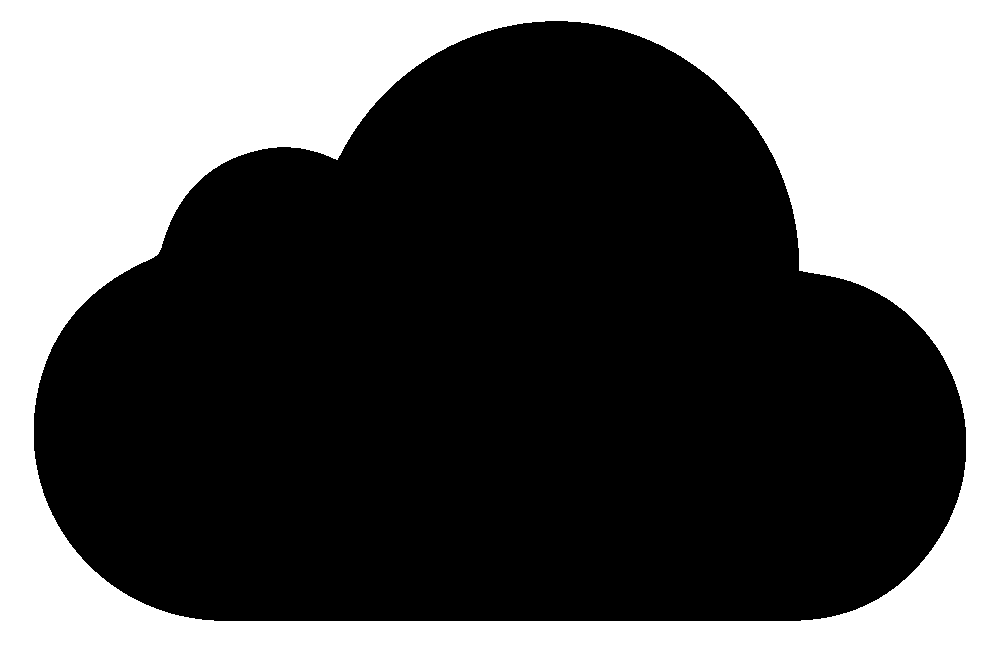

In [61]:
# Tampilkan masking
from google.colab.patches import cv2_imshow

cv2_imshow(cloud_mask)

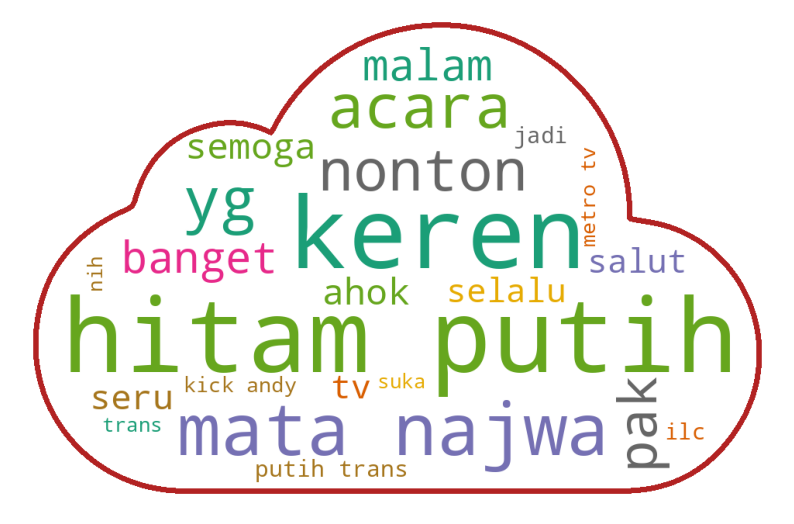

In [62]:
# WordCloud Label Cuit Positif

cuit_positif = df[df.label == 1]
normal_string = []

for t in cuit_positif.text_tweet_bersih:
  normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

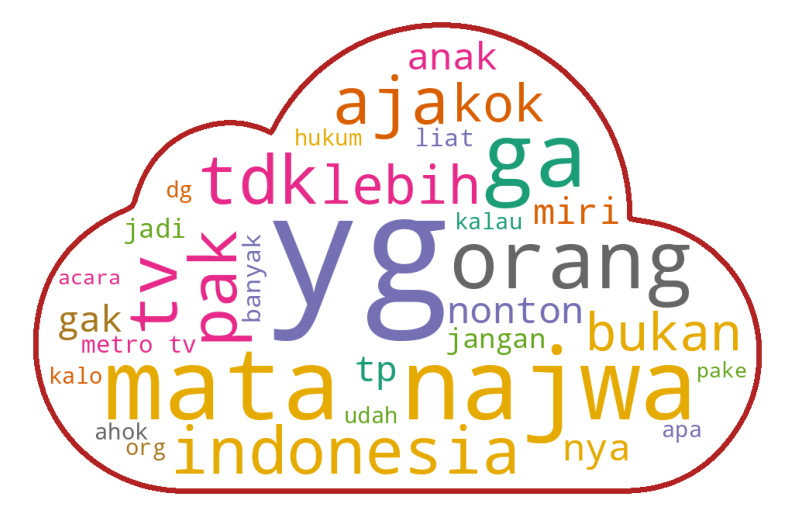

In [63]:
# WordCloud Label Cuitan Negatif

cuit_negatif = df[df.label == -1]
fraud_string = []

for t in cuit_negatif.text_tweet_bersih:
  fraud_string.append(t)

fraud_string = pd.Series(fraud_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(fraud_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()